# E5. 나랑 닮은 연예인 찾기(실습)

## 프로젝트 배경

- [출처: 머신러닝을 위한 특성 임베딩 추출 및 제공](https://cloud.google.com/architecture/overview-extracting-and-serving-feature-embeddings-for-machine-learning?hl=ko)
- 임베딩(Embedding)은 고차원 벡터를 저차원 공간으로 변환하는 것. 임베딩 공간에서 의미적으로 비슷한 입력 사항들을 가깝게 배치함으로써 입력에 포함된 의미 중 일부 포착
- 이미지 임베딩을 활용하면 이미지의 저차원적 특성 벡터(임베딩)을 추출해 이미지에 포함된 내용이 무엇인지를 나타내는 일정한 지표를 얻고, 더 효과적으로 비교할 수 있음
- 핵심은 대규모 이미지 데이터 세트(예시 - [ImageNet](https://arxiv.org/abs/1409.4842))에서 [Inception](https://arxiv.org/abs/1512.03385),[ResNet(Deep Residual Learning)](https://ai.googleblog.com/2017/11/automl-for-large-scale-image.html) 또는 [NASNet(Network Architecture Search)](https://image-net.org/)와 같은 이미지 분류 모델을 학습시키는 것
- 그런 다음 마지막 softmax 분류 기준이 없는 모델을 사용하여 입력 텍스트에 따라 특징 벡터 추출
- 예를 들어, 의류를 쇼핑 중인 고객에게 패션 아이템을 추천하는 시스템에서는 색상, 치수, 가격, 유형, 하위유형을 비롯한 개별 항목을 기술하는 속성이 사용될 수 있음
- 패션 아이템 이미지에서 추출된 특성과 함께 이러한 모든 특성을 추천 모델에서 사용할 수 있음
- 아래 그림에서의 [t-SNE MAP](https://experiments.withgoogle.com/t-sne-map) 실험은 임베딩을 사용하여 비슷한 예술작품을 찾는 예시 중 하나
- Google ML을 기반으로 t-SNE를 사용하여 유사성에 따라 매핑된 이미지
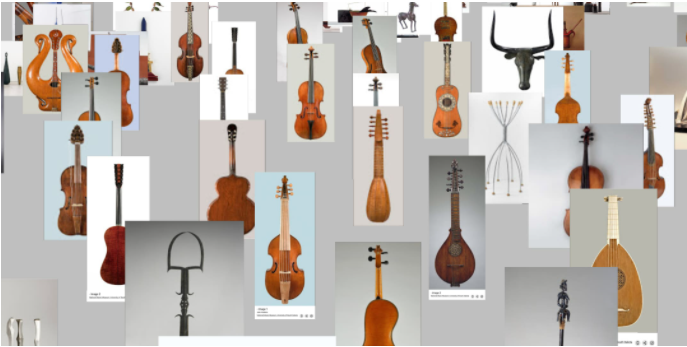

## 프로젝트 소개

- 컴퓨터비전 기술을 활용하여 얼굴의 임베딩 벡터를 추출해 나와 닮은 연예인의 얼굴을 찾아내기
- 두 얼굴이 얼마나 닮았냐의 문제는 컴퓨터한테는 **두 얼굴 벡터 사이의 거리가 얼마나 되나** 의 문제로 치환됨
- **고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는** 임베딩 기술을 활용해여 얼굴 이미지를 저차원으로 변환하고, 임베딩 벡터만으로 얼굴을 비교
- 이미지를 128 차원의 얼굴 임베딩 벡터로 변환하여 임베딩 벡터 간의 거리가 얼굴들 사이의 유사도를 얼마나 정밀하게 반영하는지 확인

## 데이터셋 소개

- 초반에는 다른 시기에 촬영된 3장의 셀카(2016년, 2018년, 2019년)으로 임베딩 거리 계산
- 연예인 사진의 경우, 웹 크롤링 기법을 통해 수집한 2086명의 연예인 사진 2086장 사용(제공자: )

## 실습 환경

- Python 3.7.9
- Numpy 1.19.5
- Matplotlib 3.3.3
- Dlib 19.9.0
- Face-recognition 1.3.0
- Pillow 8.1.0

In [1]:
# 파이썬 모듈 버전 확인하는 법
# pip list

In [2]:
import sys
print(sys.version)

3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
[GCC 9.3.0]


## 사용할 라이브러리 import

In [3]:
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img

import face_recognition

### Step 1. 사진 모으기
- 내 사진과 비교해 보고 싶은 연예인 사진 모아보기
- 평소에 닮았다고 생각했던 연예인 사진들을 모두 모아보기
- 사진을 하나의 디렉토리 안에 모아보기
- 모을 때 사진의 파일명은 가급적 '장동건.jpg', '김태희.png'와 같이 파일명이 사람 이름이 들어 있도록 하는 것이 좋음

#### 1. 내 사진 찍기
- 내 사진을 2장 이상 포함하기
- 내 사진들끼리의 얼굴 임베딩 벡터 거리 구해보기. 닮았음을 확인할 수 있는 좋은 베이스라인이 될 수 있음
- 혹시 내 사진들끼리의 거리가 멀게 나온다면 왜 그럴지 생각해보기

In [5]:
# 내 사진들끼리의 벡터 거리 계산
# 셀카 2장을 images 디렉토리에 저장
# 샘플 이미지들을 matplotlib으로 확인
dir_path = os.getenv('HOME') + '/aiffel/Exploration/Exploration_5/images/jiyoon'
file_list = os.listdir(dir_path)

print("file_list: {}".format(file_list))

file_list: ['jiyoon2.jpg', 'jiyoon.jpg', 'jiyoon3.jpg', 'my_cropped_face', '.ipynb_checkpoints']


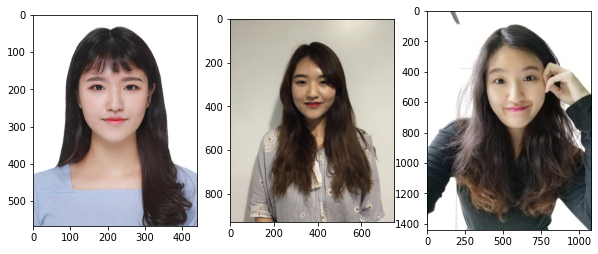

In [6]:
# Figsize 지정하기
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 15))

# Flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + '/' + file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

In [7]:
# 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수
# 하나 만들어 두면 앞으르도 유용하게 사용할 수 있을 것
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    
    return cropped_face

In [16]:
from PIL import Image
# print(image_path)
# dir_path = os.getenv('HOME') + '/aiffel/face_embedding/jiyoon/'
# file_list = os.listdir(dir_path + '/original/')

for file in file_list:
#     print(file)
    fname, ext = os.path.splitext(file)
    if ext == '.jpg':
        face = get_cropped_face(dir_path  + file)
        # plt.imshow(face)
        pillow_image = Image.fromarray(face)
        pillow_image.save(dir_path + 'my_cropped_face/' + file)


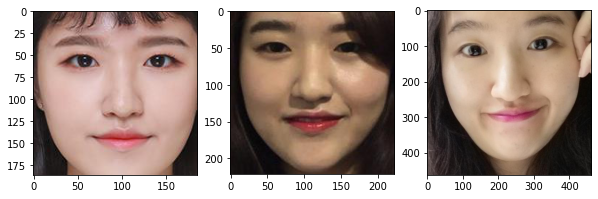

In [17]:
# Cropped된 face matplotlib으로 구현
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,10))

    # Flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + '/my_cropped_face/' + file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

In [18]:
# file_list 가져오기
import os

dir_path = os.getenv('HOME') + '/aiffel/face_embedding/jiyoon/my_cropped_face'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

file_list: ['jiyoon2.jpg', 'jiyoon.jpg', 'jiyoon3.jpg']


In [19]:
# jiyoon.jpg에 포함된 얼굴 영역의 임베딩 벡터 구하기
# 이미지 파일의 얼굴 영역 가져오는 get+cropped_face() 활용
# Face Recognition 패키지에서 얼굴 임베딩 벡터 구하는 함수는 face_recognition.face_encoding()
image_file = os.path.join(dir_path, 'jiyoon.jpg')
# 얼굴 영역을 구하는 함수(이전 스텝에서 정의)
face = get_cropped_face(image_file)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)
embedding

[array([-0.14288604,  0.05168727,  0.03929771, -0.12208254, -0.14490022,
        -0.0717106 , -0.08107836, -0.11245704,  0.1035794 , -0.17187308,
         0.1507975 , -0.09084956, -0.1789744 , -0.04696333, -0.06425678,
         0.26157853, -0.11980972, -0.16913228, -0.07379225,  0.00170887,
         0.08604886,  0.04743466, -0.02139115,  0.09043882, -0.11697622,
        -0.30580896, -0.09755107, -0.02898287, -0.0947441 , -0.00743662,
        -0.02056553,  0.08007717, -0.16554306, -0.02653684,  0.06934271,
         0.09763697, -0.00086242, -0.064913  ,  0.12203464,  0.02329314,
        -0.31862313,  0.04645473,  0.11279993,  0.24723633,  0.17234141,
         0.01949617,  0.02586361, -0.1549093 ,  0.11331084, -0.19575527,
         0.04407161,  0.11451661,  0.04368805,  0.01736432,  0.08748531,
        -0.08575799,  0.071877  ,  0.17106587, -0.14007536,  0.01557169,
         0.12813893, -0.06480093, -0.04035173, -0.17209083,  0.20916399,
         0.08849348, -0.14289501, -0.20743969,  0.1

In [ ]:
file_list

In [20]:
# images 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 dict 구조에 담아 리턴하는 함수
# 딕셔너리의 각 엘리먼트는 사람 이름: 임베딩벡터
# 함수 이름은 get_face_embedding_dict(dir_path)
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
#         print(img_path)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
        # 얼굴영역 face가 제대로 detect되지 않으면 len(embedding)==0인 경우가 발생하므로
        # os.path.splittext(file)[0]에는 이미지 파일명에서 확장자를 제거한 이름이 담김
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
    return embedding_dict  

In [21]:
# get_face_embedding_dict() 함수가 잘 만들어졌는지 확인
dir_path = os.getenv('HOME') + '/aiffel/face_embedding/jiyoon/my_cropped_face'
# crop_path = os.getenv('HOME') + '/aiffel/Exploration/Exploration_5/images/jiyoon/my_cropped_face'
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['jiyoon']

array([-0.14288604,  0.05168727,  0.03929771, -0.12208254, -0.14490022,
       -0.0717106 , -0.08107836, -0.11245704,  0.1035794 , -0.17187308,
        0.1507975 , -0.09084956, -0.1789744 , -0.04696333, -0.06425678,
        0.26157853, -0.11980972, -0.16913228, -0.07379225,  0.00170887,
        0.08604886,  0.04743466, -0.02139115,  0.09043882, -0.11697622,
       -0.30580896, -0.09755107, -0.02898287, -0.0947441 , -0.00743662,
       -0.02056553,  0.08007717, -0.16554306, -0.02653684,  0.06934271,
        0.09763697, -0.00086242, -0.064913  ,  0.12203464,  0.02329314,
       -0.31862313,  0.04645473,  0.11279993,  0.24723633,  0.17234141,
        0.01949617,  0.02586361, -0.1549093 ,  0.11331084, -0.19575527,
        0.04407161,  0.11451661,  0.04368805,  0.01736432,  0.08748531,
       -0.08575799,  0.071877  ,  0.17106587, -0.14007536,  0.01557169,
        0.12813893, -0.06480093, -0.04035173, -0.17209083,  0.20916399,
        0.08849348, -0.14289501, -0.20743969,  0.14685658, -0.13

In [ ]:
embedding_dict

In [22]:
embedding_dict['jiyoon2']

array([-1.50418386e-01,  1.03687719e-01,  6.98367879e-02, -1.33560419e-01,
       -1.63108006e-01,  4.67654783e-04, -9.06218886e-02, -4.13196608e-02,
        1.01570345e-01, -2.03357294e-01,  1.69870719e-01, -1.11883014e-01,
       -2.17820704e-01, -7.87974568e-04, -4.52369563e-02,  2.14495152e-01,
       -1.23501226e-01, -1.53127626e-01, -3.59686054e-02,  1.98367275e-02,
        1.13458149e-01,  3.80093046e-02, -4.32502385e-03,  6.68504387e-02,
       -1.20557606e-01, -3.77607793e-01, -8.27247277e-02, -7.81154819e-03,
       -9.46617499e-02, -8.01120549e-02, -2.08276268e-02,  7.84199312e-02,
       -2.10043982e-01,  2.56799459e-02, -1.36919208e-02,  1.39325187e-01,
       -2.17103399e-02, -7.08886832e-02,  1.39058456e-01,  3.44995409e-02,
       -3.11340153e-01,  5.85196130e-02,  6.78802505e-02,  2.39420414e-01,
        1.63061768e-01,  2.06385856e-04,  9.02418047e-03, -1.04572915e-01,
        1.17978513e-01, -1.66944832e-01,  4.01996151e-02,  1.50424421e-01,
        5.44822365e-02,  

In [23]:
# 두 임베딩 벡터 간의 거리를 계산하는 함수 구현
# np.linalg.norm 활용
# 아래의 get_distance() 함수는 인자로 파일명의 사람 이름 2개를 받아서, 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구하는 형태
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1] - embedding_dict[name2], ord = 3)

# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 함
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1
sort_key_func = get_sort_key_func('jiyoon2')

In [24]:
sorted(embedding_dict.items(), key = lambda x:sort_key_func(x[0]))

[('jiyoon2',
  array([-1.50418386e-01,  1.03687719e-01,  6.98367879e-02, -1.33560419e-01,
         -1.63108006e-01,  4.67654783e-04, -9.06218886e-02, -4.13196608e-02,
          1.01570345e-01, -2.03357294e-01,  1.69870719e-01, -1.11883014e-01,
         -2.17820704e-01, -7.87974568e-04, -4.52369563e-02,  2.14495152e-01,
         -1.23501226e-01, -1.53127626e-01, -3.59686054e-02,  1.98367275e-02,
          1.13458149e-01,  3.80093046e-02, -4.32502385e-03,  6.68504387e-02,
         -1.20557606e-01, -3.77607793e-01, -8.27247277e-02, -7.81154819e-03,
         -9.46617499e-02, -8.01120549e-02, -2.08276268e-02,  7.84199312e-02,
         -2.10043982e-01,  2.56799459e-02, -1.36919208e-02,  1.39325187e-01,
         -2.17103399e-02, -7.08886832e-02,  1.39058456e-01,  3.44995409e-02,
         -3.11340153e-01,  5.85196130e-02,  6.78802505e-02,  2.39420414e-01,
          1.63061768e-01,  2.06385856e-04,  9.02418047e-03, -1.04572915e-01,
          1.17978513e-01, -1.66944832e-01,  4.01996151e-02,  1.

In [25]:
# 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 출력
def get_nearest_face(name, top = 3):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key = lambda x:sort_key_func(x[0]))
    
    for i in range(top):
#         첫번째로 나오는 이름은 자기 자신일 것이므로 제외
        if i == 0:
            continue
        if sorted_faces[i]:
            print('순위 {}: 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [26]:
get_nearest_face('jiyoon2', 3)

순위 1: 이름(jiyoon), 거리(0.19654304036346235)
순위 2: 이름(jiyoon3), 거리(0.20117537912477168)


#### 2. 비교할 연예인 사진 모으기
- 많이 모을수록 나와 더 닮은 연예인을 찾을 가능성이 높아질 것
- 주위의 동료들과 모은 사진을 주고받는 것도 하나의 방법

In [27]:
# 연예인 이미지파일 리스트 확인
dir_path = os.getenv('HOME') + '/aiffel/Exploration/Exploration_5/images/data'
file_list = os.listdir(dir_path)

print('file_list: {}'.format(file_list))

file_list: ['최락.jpg', '박건형.jpg', '문연주.jpg', '최승훈.jpg', '박원상.jpg', '신미래.jpg', '설수진.jpg', '송종호.jpg', '노정의.jpg', '박영규.jpg', '김예준.jpg', '이재은.jpg', '한갑수.jpg', '이유비.jpg', '김나운.jpg', '정겨운.jpg', '사문영.jpg', '서인영.jpg', '하나경.jpg', '신은수.jpg', '신해철.jpg', '백일섭.jpg', '무진성.jpg', '서영.jpg', '한소희.jpg', '서이안.jpg', '고나은.jpg', '혜은이.jpg', '이상인.jpg', '최오식.jpg', '조현민.jpg', '전종서.jpg', '김지미.jpg', '조민수.jpg', '김환성.jpg', '백수련.jpg', '김국희.jpg', '전여빈.jpg', '금새록.jpg', '김보경.jpg', 'G-DRAGON.jpg', '김그림.jpg', '민지영.jpg', '김흥수.jpg', '김조한.jpg', '현인.jpg', '유승우.jpg', '김승미.jpg', '손종학.jpg', '류혜영.jpg', '한채아.jpg', '소아린.jpg', '최유라.jpg', '김창완.jpg', '이정.jpg', '김영호.jpg', '공유.jpg', '이은하.jpg', '김태연.jpg', '이유미.jpg', '윤여정.jpg', '손창민.jpg', '황승언.jpg', '이난영.jpg', '김인권.jpg', '인쿠.jpg', '장근석.jpg', '데프콘.jpg', '배용준.jpg', '영탁.jpg', '조성하.jpg', '김새론.jpg', '윤미래.jpg', '강예솔.jpg', '심신.jpg', '손유동.jpg', '이자인.jpg', '양정아.jpg', '이미배.jpg', '정혜성.jpg', '김하영.jpg', '최유나.jpg', '김응수.jpg', '문가영.jpg', '고보결.jpg', '최지연.jpg', '황정리.jpg', '김종국.jpg', '채민서.jpg', '이하늬.jpg', '

In [28]:
# 이미지 파일의 총 개수
print(len(file_list))

2086


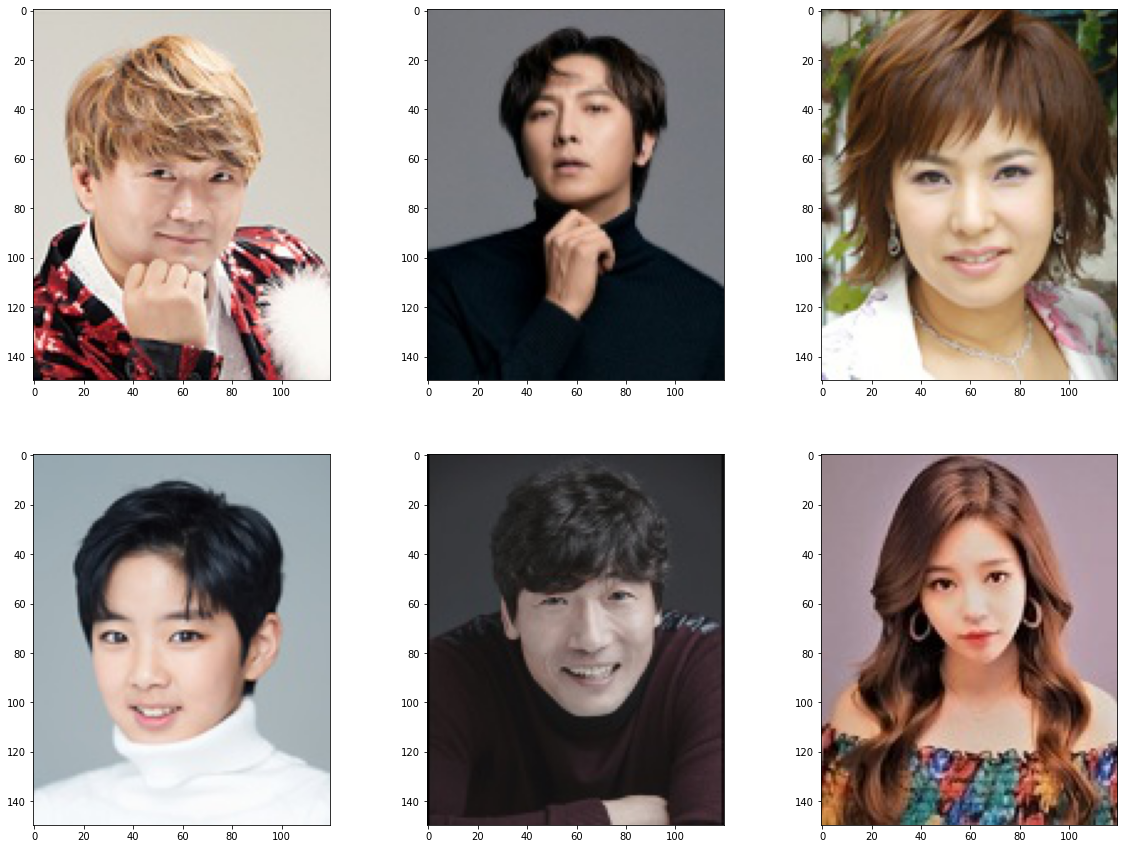

In [30]:
# Figsize 지정하기
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 15))

# Flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + '/' + file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

### Step 2. 얼굴 영역 자르기
- 임베딩 추출을 위해 얼굴 영역 잘라주기
- Step1에서 찾은 이미지들을 이전에 만들었던 get_cropped_face(image_file)을 통해서 잘라주기
- 자르이미지는 PIL의 Image.fromarray를 통해서 PIL Image로 변환한 뒤에 저장을 해두면 다양한 재미있는 시각화를 시도해 보는데 도움이 될 것

In [31]:
# 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수
# 하나 만들어 두면 앞으르도 유용하게 사용할 수 있을 것
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    
    return cropped_face

In [34]:
from PIL import Image

for f in file_list:
    fname, ext = os.path.splitext(f)
    pillow_image = Image.fromarray(face)
    pillow_image.save(dir_path + '/my_cropped_face/' + f)

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/Exploration/Exploration_5/images/data/my_cropped_face/최락.jpg'

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/Exploration/Exploration_5/images/data/my_cropped_face/최락.jpg'

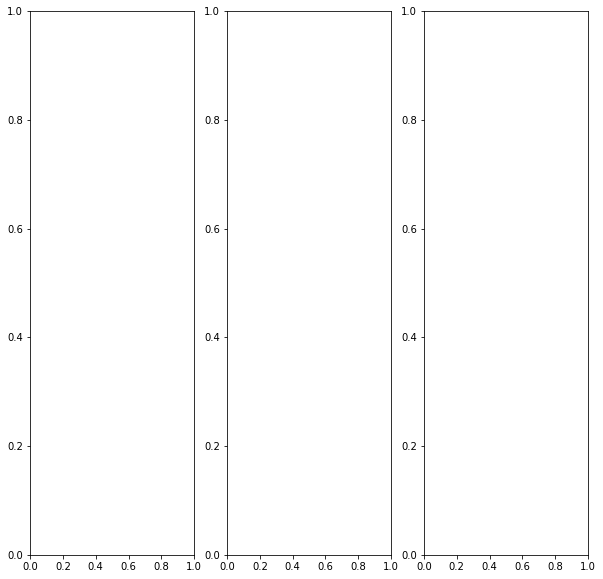

In [33]:
# Cropped된 face matplotlib으로 구현
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,10))

    # Flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + '/my_cropped_face/' + file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

### Step 3. 얼굴 영역의 임베딩 추출하기
- 얼굴 영역으로 잘린 이미지를 face_recognition을 사용해서 이미지들을 불러오고 임베딩 추출
- 다른 사람의 임베딩은 구분할 수 있게 따라 저장하기
- def get_face_embedding(face): 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- def get_face_embedding_dict(dir_path): 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

### Step 4. 모은 연예인들과 비교하기
- 모은 연예인 사진들과 자신의 얼굴 사진에서 추출한 임베딩 벡터들 간의 거리를 비교해 보고 가장 작은 연예인이 누군지 찾아보기
- 이전 스텝에서 만들었던 get_nearest_face(name, top=5) 함수들을 응용하면 손쉽게 수행 가능

### Step 5. 다양한 재미있는 시각화 시도해 보기
- 비단 닮은 꼴 연예인을 찾기만 할 것이 아니라, 그들의 얼굴 사진을 활용하여 재미있는 시각화 시도해보기
- tkinter나 flask를 활용해서 닮은 꼴을 찾을 이미지를 업로드한 후, 그 이미지와 닮은 얼굴을 찾는 형태로 구현